# Example 12 Singlet fission with bath modes

**This example takes a while. I recommend execution on HPC and select JAX as wrapper**

- References
  - [Chin, Alex W., et al. "Exact mapping between system-reservoir quantum models and semi-infinite discrete chains using orthogonal polynomials." Journal of Mathematical Physics 51.9 (2010).](https://doi.org/10.1063/1.3490188)
  - [Zheng, Jie, et al. "Ultrafast nonadiabatic dynamics of singlet fission: Quantum dynamics with the multilayer multiconfigurational time-dependent Hartree (ML-MCTDH) method." The Journal of Physical Chemistry C 120.3 (2016): 1375-1389.](https://pubs.acs.org/doi/abs/10.1021/acs.jpcc.5b09921)

In [1]:
import platform
import sys

import pytdscf

print(sys.version)
print(f"pytdscf version = {pytdscf.__version__}")
print(platform.platform())

import jax.extend

print(jax.extend.backend.get_backend().platform)

3.12.2 (main, Feb  6 2024, 20:19:44) [Clang 15.0.0 (clang-1500.1.0.2.5)]
pytdscf version = 1.0.3
macOS-14.4.1-arm64-arm-64bit
cpu


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import sympy
from pympo import AssignManager, OpSite, SumOfProducts

from pytdscf import BasInfo, Exciton, Boson, Model, Simulator, units, TensorOperator, TensorHamiltonian

## Model Hamiltonian

$$
H = H_{\text{ele}} + H_{\text{ph}} + H_{\text{el-ph}}
$$

where $H_{\text{ele}}$ is the electronic Hamiltonian consisting of three sites (S1, TT, CS in this order)
and represented by following effective Hamiltonian

$$
H_{\text{ele}} = \begin{pmatrix}
0.2 & 0 & -0.05 \\
0 & 0 & -0.05 \\
-0.05 & -0.05 & 0.3
\end{pmatrix}
$$


and $H_{\text{ph}}$ and $H_{\text{el-ph}}$ are the phonon and electron-phonon coupling Hamiltonians, respectively.

$$
H_{\text{ph}} + H_{\text{el-ph}} 
 = \sum_{k} |k\rangle \langle k| c_0 (b_0 + b_0^\dagger) + \sum_{n=1}^N (\omega_n b_n^\dagger b_n + t_n b_{n+1}^\dagger b_n + t_n b_n^\dagger b_{n+1})
$$

For detail derivation of this reserovir model, please refer to the [reference](https://doi.org/10.1063/1.3490188).

We will set the electronic state as the left terminal site (i=0) and the bath modes as i=1 to N+1 sites.

### Spectral density

The [previous study](https://pubs.acs.org/doi/abs/10.1021/acs.jpcc.5b09921) employed the spectral density defined as Debye type (Lorentzian decaying)
$$
J_{\text{Debye}}(\omega) = \frac{2\lambda \omega \omega_c}{\omega_c^2 + \omega^2}
$$
with a finite cutoff frequency $\omega_c$.

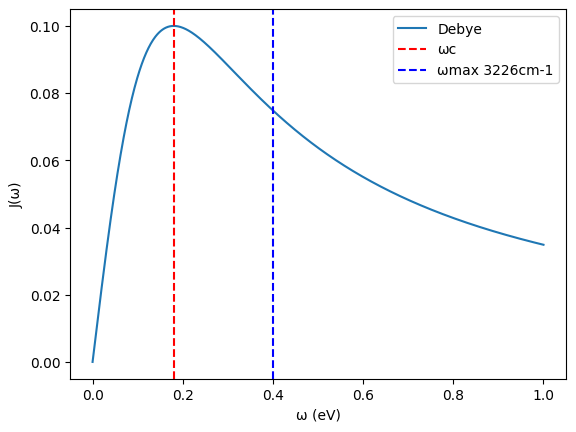

In [3]:
ωc = 0.18  # eV a.k.a charactaristic frequency
λ = 0.10  # eV a.k.a reorganization energy
ωmax = 0.40

def J_debye(ω):
    return 2 * λ * ω * ωc / (ω * ω + ωc * ωc)

omega = np.linspace(0.0, 1.0, 1000)
plt.plot(omega, J_debye(omega), label="Debye")
plt.xlabel("ω (eV)")
plt.ylabel("J(ω)")
plt.axvline(x=ωc, color="red", linestyle="--", label="ωc")
plt.axvline(x=ωmax, color="blue", linestyle="--", label="ωmax 3226cm-1")
plt.legend()
plt.show()

The easiest transformation to finite number of harmonic oscillators is just
discretizing integral
$$
\begin{align}
& H_{\text{sys}} + H_{\text{res}} + V
\\
&= 
H_{\text{sys}} 
+ \int_0^{x_{\text{max}}} dx g(x) a_{x} a_{x}^\dagger 
+ \int_0^{x_{\text{max}}} dx h(x) \hat{A} (a_{x} + a_{x}^\dagger)
\\
&\approx
H_{\text{sys}}
+ \sum_{n=1}^N \omega_n a_n^\dagger a_n
+ \sum_{n=1}^N c_n \hat{A} (a_n + a_n^\dagger)
\end{align}
$$
$N$ is usually required to be a hundred number to represent the continuous spectral density.

However, there exists a more sophisticated method to map the continuous spectral density to the discrete chain with nearest neighbor coupling.

## Orthogonal polynomial mapping

We will define spectral density as 
$$
J(\omega) = \frac{2\lambda \frac{\omega}{\omega_c}}{1+\left(\frac{\omega}{\omega_c}\right)^2} \theta\left(\frac{\omega}{\omega_{\text{max}}} - 1\right)
$$
where $\theta(x)$ is the Heaviside step function. 
When we set $g(x) = \omega_{\text{max}} x$ and $x_{\text{max}}=1$, from the following relation
$$
J(\omega) = \pi h^2\left(\frac{\omega}{\omega_{\text{max}}}\right) \frac{1}{\omega_{\text{max}}},
$$
we can extract constant $C=2\lambda\omega_c / \pi$ and define measure
$$
\mu(x) := \frac{h^2(x)}{C} = \frac{x}{\frac{1}{L^2}+x^2} \quad \left(0<x<1, L=\frac{\omega_{\text{max}}}{\omega_c}\right)
$$
and orthogonal monic polynomials $\{\pi_n\}$ which satisfy
$$
\Braket{\pi_n,\pi_m}_{\mu} = \int_0^1 \pi_n(x) \pi_m(x) \mu(x) dx
= \delta_{nm} ||\pi_n||^2
$$
and
$$
\pi_{n+1} = (x-\alpha_n) \pi_n - \beta_n \pi_{n-1}
$$
where $\pi_0 = 1$ and $\pi_{-1} = 0$.

The goal is to find recursion coefficients $\alpha_n$ and $\beta_n$ which satisfy
$$
\alpha_n = \frac{\Braket{x\pi_n, \pi_n}_{\mu}}{\Braket{\pi_n, \pi_n}_{\mu}}
$$
and
$$
\beta_n = \frac{\Braket{\pi_n, \pi_n}_{\mu}}{\Braket{\pi_{n-1}, \pi_{n-1}}_{\mu}}.
$$

First we need to prepare the $k$-th moment of the measure up to $k=2N$.
$$
m_k = \int_0^1 x^k \mu(x) dx = 
\int_0^1 \frac{x^{k+1}}{\frac{1}{L^2}+x^2} dx =
L\int_0^{\arctan L} \left(\frac{\tan\theta}{L}\right)^{k+1} d\theta
$$
$$
m_k = \frac{1}{k} - \frac{1}{L^2}m_{k-2}, \quad 
m_0 = -\log(\cos(\arctan(L))) = \frac{1}{2} \log(1+L^2)
, \quad m_1 = 1 - \frac{1}{L}\arctan L
$$
Then, we determine the coefficients $\alpha_n$ and $\beta_n$ recursively.

Note that recursive calculation tends to accumulate errors, so we will use `mpmath` to calculate the coefficients.

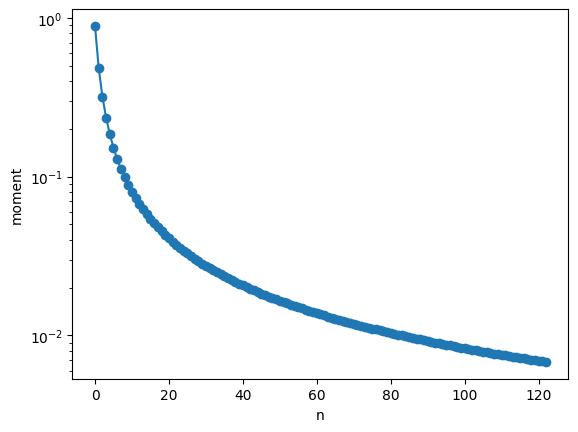

In [4]:
from mpmath import mp, mpf
mp.dps = 512

def get_momments(n_order, L=1.0, factor=1.0): 
    #moments = [mpf(1/2 * math.log(1+L**2)), mpf(L-math.atan(L))]
    moments = [mpf(1) / mpf(2) * mp.log1p(mpf(L) ** 2), 1 - mp.atan(mpf(L))/mpf(L)]
    for k in range(2, 2*n_order+1):
        # moments.append(1 / k - moments[-2])
        moments.append(1 / mpf(k) - moments[-2] / mpf(L) / mpf(L))
    if factor != 1.0:
        factor = mpf(factor)
        moments = [moment * factor ** i for i, moment in enumerate(moments)]
    return moments


n_order = 61
factor = 1.0
L = ωmax / ωc
moments = get_momments(n_order, L, factor)

plt.plot(moments, marker="o")
plt.xlabel("n")
plt.ylabel("moment")
plt.yscale("log")
plt.axhline(0.0, color="black", linestyle="--")
plt.show()

In [5]:
def polynomial_inner_product(poly1: np.ndarray, poly2: np.ndarray, moments: np.ndarray):
    """
    Calculate the inner product of two polynomials using the moments.

    Args:
        poly1: Coefficients of the first polynomial. [1.0, 2.0, 3.0] means 1 + 2x + 3x^2
        poly2: Coefficients of the second polynomial. [1.0, 2.0, 3.0] means 1 + 2x + 3x^2
        moments: Moments used to calculate the inner product.
    """
    assert len(poly1) + len(poly2) - 1 <= len(moments)
    # convolution = np.convolve(poly1, poly2)
    # return np.dot(convolution, moments[:len(convolution)])
    convolution = [mpf(0)] * (len(poly1) + len(poly2) - 1)
    for i in range(len(poly1)):
        for j in range(len(poly2)):
            convolution[i+j] += poly1[i] * poly2[j]
    return sum(c *m for c,m in zip(convolution, moments[:len(convolution)]))


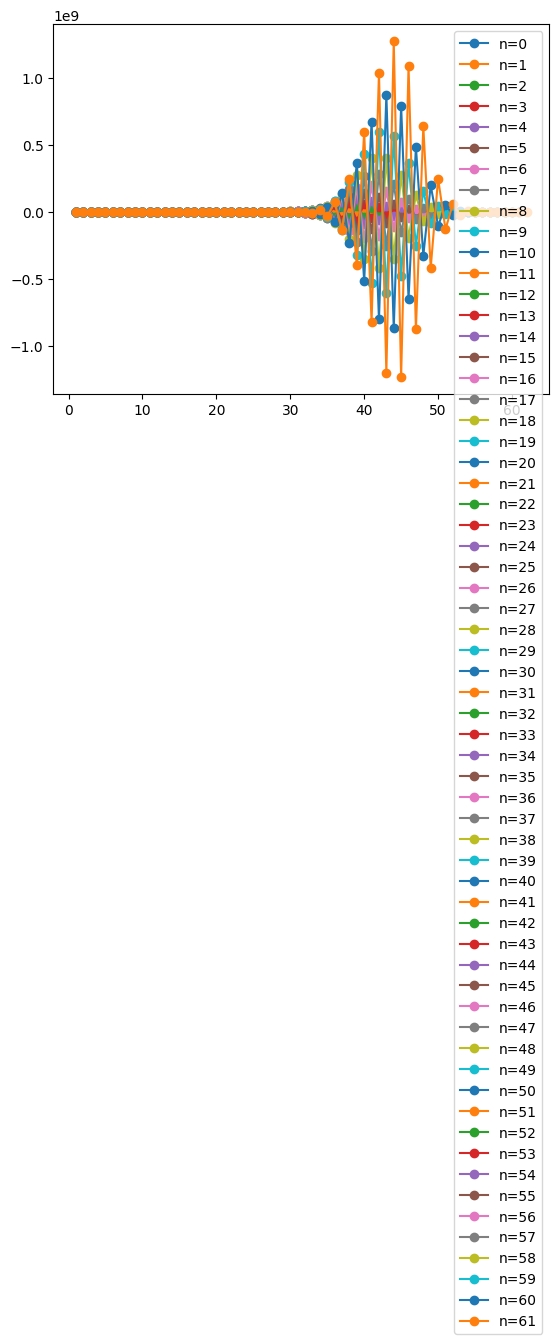

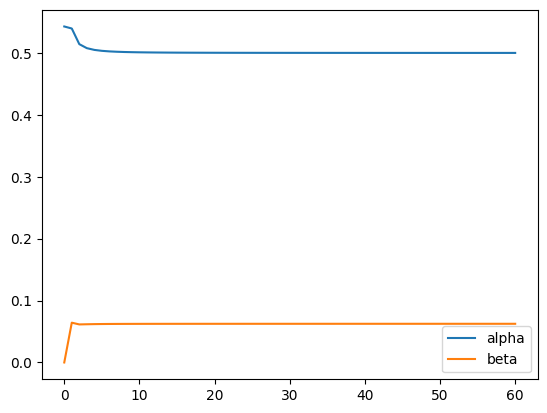

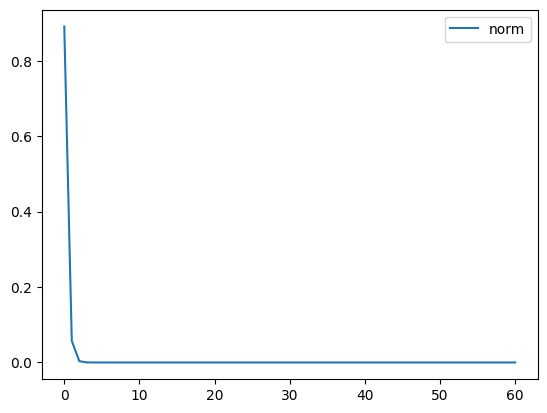

In [6]:

def get_coef_alpha_beta_recursive(n_order, moments):
    # monic_coefs = [[1.0]]
    monic_coefs = [[mpf(1)]]
    alpha = []
    beta = []
    norm = [] # <pi_k,pi_k>
    for n in range(n_order):
        # coefs_pi_k = [0.0] + monic_coefs[-1]
        coefs_pi_k = [mpf(0)] + monic_coefs[-1]
        # coefs_x_pi_k = monic_coefs[-1] + [0.0]
        coefs_x_pi_k = monic_coefs[-1] + [mpf(0)]
        assert coefs_x_pi_k[0] == 1.0
        # <pi_k,pi_k>
        alpha_denom = polynomial_inner_product(np.array(coefs_pi_k)[::-1], np.array(coefs_pi_k)[::-1], np.array(moments))
        # <x pi_k,pi_k>
        alpha_num = polynomial_inner_product(np.array(coefs_x_pi_k)[::-1], np.array(coefs_pi_k)[::-1], np.array(moments))
        alpha.append(alpha_num / alpha_denom)
        norm.append(alpha_denom)
        if n >= 1:
            beta_num = norm[-1]
            beta_denom = norm[-2]
            beta.append(beta_num / beta_denom)
        else:
            # beta.append(0.0)
            beta.append(mpf(0))
        monic_coefs.append(coefs_x_pi_k)
        for i in range(len(monic_coefs[-2])):
            monic_coefs[-1][-i-1] -= alpha[-1] * monic_coefs[-2][-i-1]
        if n >= 1:
            for i in range(len(monic_coefs[-3])):
                monic_coefs[-1][-i-1] -= beta[-1] * monic_coefs[-3][-i-1]
    return monic_coefs, alpha, beta, norm

monic_coefs, alpha, beta, norm = get_coef_alpha_beta_recursive(n_order, moments)

# monic_coefをすべてplot (足りない部分は0)
for i in range(len(monic_coefs)):
    plt.plot(np.arange(i+1, 0, -1), monic_coefs[i], label=f"n={i}", marker="o")
plt.legend()
plt.show()

plt.plot(alpha, label="alpha")
plt.plot(beta, label="beta")
plt.legend()
plt.show()

plt.plot(norm, label="norm")
plt.legend()
plt.show()

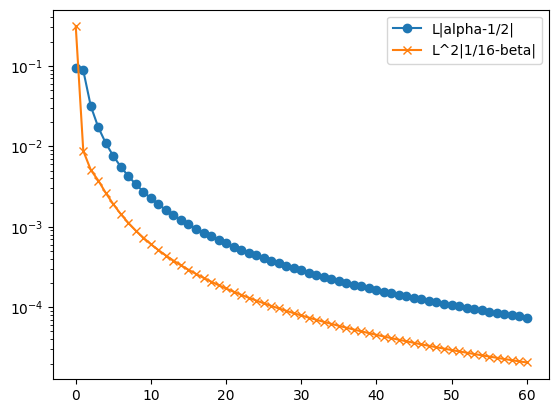

In [7]:
plt.plot(np.abs(np.array(alpha)-1/2)*L, label="L|alpha-1/2|", marker="o")
plt.plot(np.abs(1/16-np.array(beta))*L*L, label="L^2|1/16-beta|", marker="x")
plt.yscale("log")
plt.legend()
plt.show()

Then, we have the parameters

$$
c_0 = |\pi_0| = \sqrt{m_0} = \sqrt{\frac{1}{2} \log(1+L^2)}
$$
$$
\omega_n = \omega_{\text{max}} \alpha_n
$$
$$
t_n = \omega_{\text{max}} \sqrt{\beta_{n+1}}
$$

And total Hamiltonian is
$$
H_{\text{sys}} + \sqrt{\frac{\lambda\omega_c\log(1+L^2)}{\pi}} \hat{A} (b_0 + b_0^\dagger) + \sum_{n=0}^N \omega_{\text{max}}(\alpha_n b_n^\dagger b_n + \sqrt{\beta_{n+1}} b_{n+1}^\dagger b_n + \sqrt{\beta_{n+1}} b_n^\dagger b_{n+1})
$$
where $\hat{A}$ is the operator like $\sum_{k} |k\rangle \langle k|$ acting on the electronic state.

In [8]:
assert False
backend = "jax"
c0 = math.sqrt(λ*ωc*math.log(1+L**2) / math.pi) /  units.au_in_eV
omega = np.array(alpha, dtype=np.float64) * ωmax / units.au_in_eV
t = np.sqrt(np.array(beta[1:], dtype=np.float64)) * ωmac / units.au_in_eV

c0_sym = sympy.Symbol('c_0')
omega_syms = [sympy.Symbol(f'omega_{i}') for i in range(len(omega))]
t_syms = [sympy.Symbol(f't_{i}') for i in range(len(t))]

subs = {}
subs[c0_sym] = c0
for omega_val, omega_sym in zip(omega, omega_syms, strict=True):
    subs[omega_sym] = omega_val
for t_val, t_sym in zip(t, t_syms, strict=True):
    subs[t_sym] = t_val

AssertionError: 

### Setup basis for wavefunction

In [ ]:
basis = [Exciton(nstate=3, names=['S1', 'TT', 'CS'])] + [Boson(8)] * len(omega) * 3
basinfo = BasInfo([basis])
ndim = len(basis)
print(ndim)

### Setup one particle operator

In [ ]:
eham = np.array([
    [0.2, 0.0, -0.05],
    [0.0, 0.0, -0.05],
    [-0.05, -0.05, 0.3]
]) / units.au_in_eV
#eham -= np.diag([0.5, 0.5, 0.5]) / 3 / units.au_in_eV # Shift trace to be 0
b = basis[1].get_annihilation_matrix()
bdag = basis[1].get_creation_matrix()
num = basis[1].get_number_matrix()
bdagb = num
print(bdagb)

ct = np.zeros((3,3))
ct[2,2] = 1.0 # act only on CT

s1 = np.zeros((3,3))
s1[0,0] = 1.0 # act only on S1

tt = np.zeros((3,3))
tt[1,1] = 1.0 # act only on TT

eham_op = OpSite("H_0", 0, value=eham)
ct_op = OpSite("CT_0", 0, value=ct)
s1_op = OpSite("S1_0", 0, value=s1)
tt_op = OpSite("TT_0", 0, value=tt)

b_ops = [None] + [OpSite("b_{" + f"{i}" + "}", i, value=b) for i in range(1, ndim)]
bdag_ops = [None] + [OpSite(r"b^\dagger"+ "_{" + f"{i}" + "}", i, value=bdag) for i in range(1, ndim)]
bdagb_ops = [None] + [OpSite(r"b^\dagger"+ "_{"+ f"{i}" + "}"+"b_{"+f"{i}"+"}", i, value=bdagb) for i in range(1, ndim)]

### Setup potential and kinetic operator

In [ ]:
pot_sop = SumOfProducts()

pot_sop += eham_op
pot_sop += c0_sym * s1_op * (b_ops[1] + bdag_ops[1])
pot_sop += c0_sym * tt_op * (b_ops[1+n_order] + bdag_ops[1+n_order])
pot_sop += c0_sym * ct_op * (b_ops[1+2*n_order] + bdag_ops[1+2*n_order])
for i in range(1, 1+n_order):
    for k in range(3):
        shift = n_order * k
        pot_sop += omega_syms[i-1] * bdagb_ops[i+shift]
        if i < n_order:
            pot_sop += t_syms[i-1] * (b_ops[i+shift] * bdag_ops[i+1+shift] + bdag_ops[i+shift] * b_ops[i+1+shift])
        
pot_sop = pot_sop.simplify()
pot_sop.symbol

### Setup MPO

In [ ]:
am_pot = AssignManager(pot_sop)
am_pot.assign()
display(*am_pot.Wsym)
W_prod = sympy.Mul(*am_pot.Wsym)
assert W_prod[0] == pot_sop.symbol
print(*[f"W{i}" for i in range(am_pot.ndim)], "=")
display(W_prod[0].expand())
pot_mpo = am_pot.numerical_mpo(subs=subs)

### Setup Hamiltonian

In [ ]:
# MPO has legs on (0,1,2, ... ,f-1) sites. This legs are given by tuple key
potential = [
    [
        {
            tuple((k, k) for k in range(ndim)): TensorOperator(
                mpo=pot_mpo
            )
        }
    ]
]  # key is ((0,0), 1, 2, ..., ndim-1)

H = TensorHamiltonian(
    ndof=len(basis), potential=potential, kinetic=None, backend=backend
)

core = np.zeros((1,3,1))
core[0, 0, 0] = 1.0
s1 = TensorHamiltonian(ndof=len(basis), potential=[[{(0,): TensorOperator(mpo=[core], legs=(0,))}]], kinetic=None, backend=backend)
operators = {"hamiltonian": H, 'S1': s1}

sites = list(range(1, n_order+1, 4)) + list(range(1 + n_order, 2*n_order+1, 4)) + list(range(1 + 2*n_order, 3*n_order+1, 4))
for isite in sites:
    core = np.zeros((1,basis[isite].nprim,1))
    core[0, :, 0] = np.arange(basis[isite].nprim)
    n = TensorHamiltonian(ndof=len(basis), potential=[[{(isite,): TensorOperator(mpo=[core], legs=(isite,))}]], kinetic=None, backend=backend)
    operators[f'N{isite}'] = n

### Setup Model (basis, operators, initial states)

In [ ]:
model = Model(basinfo=basinfo, operators=operators)
model.m_aux_max = 20
# Starts from S1 state
init_boson = [[1.0] + [0.0] * (basis[1].nprim - 1)]
model.init_HartreeProduct = [[[1.0, 0.0, 0.0]]+init_boson * (ndim-1)]
print(model.init_HartreeProduct)

### Execution

In [ ]:
jobname = "singlet_fission"
simulator = Simulator(jobname=jobname, model=model, backend=backend, verbose=2)
simulator.propagate(
    maxstep=2000,
    stepsize=0.2,
    reduced_density=(
        [(0, 0)],
        10,
    ),  # we want to know diagonal_element of (|S1><S1| |CS><CS| |TT><TT| |S1><CS| |S1><TT| |CS><TT|) on (|0><0|)
    energy=False,
    autocorr=False,
    observables=True,
    observables_per_step=10,
)

### Check results (reduced densities)

In [ ]:
import netCDF4 as nc

with nc.Dataset(f"{jobname}_prop/reduced_density.nc", "r") as file:
    density_data_real = file.variables["rho_(0, 0)_0"][:]["real"]
    time_data = file.variables["time"][:]

In [ ]:
plt.title(f'# of site = {len(basis)}, $ω_c$={ωc} [eV], $ωmax$={ωmax} [eV]')
plt.ylabel('Population')
plt.xlabel('Time [fs]')
plt.plot(time_data, density_data_real[:, 0, 0], label="S1")
plt.plot(time_data, density_data_real[:, 1, 1], label="TT")
plt.plot(time_data, density_data_real[:, 2, 2], label="CT")
plt.plot(time_data, density_data_real[:, 0, 2], label="Re|CT><S1|")
plt.legend()
plt.show()

In [ ]:
import polars as pl
import re

path = f"{jobname}_prop/expectations.dat"
with open(path, "r") as f:
    header = f.readline().strip()
    columns = re.split(r"\s+", header)
    columns = [columns[1]] + columns[3:]

    data = f.readlines()

df = pl.read_csv(
    path,
    separator="\t",
    new_columns=columns,
    has_header=False,
    skip_rows=1,
    schema_overrides={col: pl.Float64 for col in columns}, 
)
plt.figure(figsize=(27, 10))
plt.imshow(df[columns[2:]], aspect=5.e-02)
plt.colorbar()
plt.ylabel('time [fs]')
plt.yticks(np.arange(len(df))[::50], df['time'][::50])
plt.xticks(np.arange(len(columns)-2), [name[1:] for name in columns[2:]])
plt.title(r'$\langle \hat{N}_i \rangle$')
plt.show()